In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy import stats
from scipy.stats import sem
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from pylab import show, figure
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from matplotlib.lines import Line2D
# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.odr import *

In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, catchment_outlet_ids, 
                         step_size_m, comparison_distance_m, change_detection_factor, slope_above_head):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    upslope_divergence_dict = {}
    slope_dict = {}
    slope_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                    
        area_along_central_drainage_line = []
        for key, value in node_area_dict.items():
            area_along_central_drainage_line.append(value)
        median_area_along_central_drainage_line = ndimage.median_filter(area_along_central_drainage_line, size=step_size_m)
        slope_along_central_drainage_line = []
        for key, value in slope_mean_dict.items():
            slope_along_central_drainage_line.append(value)
        slope_mean_above_gully = np.mean(np.array(slope_along_central_drainage_line))
        slope_dict[i] = slope_mean_above_gully
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_area_along_central_drainage_line) < required_number_of_grid_cells:
            upslope_divergence_dict[i] = 'not enough grid cells'
        else:
            divergence_occuring = upslopeDivergence(median_area_along_central_drainage_line, change_detection_factor, 
                                                    step_size, comparison_distance)
            upslope_divergence_dict[i] = divergence_occuring
            
    return upslope_divergence_dict, slope_dict, slope_at_head

In [185]:
input_DEM_resolution = 5

location = (r'C:\PhD\manuscript\flow_routing_algorithms\data')
os.chdir(location)

input_geotiff = gdal.Open('fann_2013_' + str(input_DEM_resolution) + 'm.tif')
input_DEM = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

gully_head_layer = gdal.Open('core_nodes_' + str(input_DEM_resolution) + 'm.tif')
gh = np.array(gully_head_layer.GetRasterBand(1).ReadAsArray()).astype('uint8')

input_ca_grid = gdal.Open('fann_M8_' + str(input_DEM_resolution) +  'm.tif')
ca_grid = np.array(input_ca_grid.GetRasterBand(1).ReadAsArray())

In [186]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [187]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))

In [188]:
grid_nodes_float = grid_nodes.astype('float64')

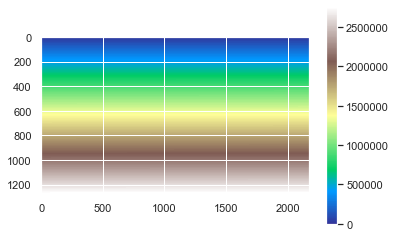

In [189]:
plt.imshow(grid_nodes_float, cmap="terrain");
plt.colorbar();

## Isolate all gully head nodes

In [190]:
find_nodes = np.multiply(gh, grid_nodes);

## Create array of only gully head nodes 

In [191]:
gh_array = np.unique(find_nodes);

## Turn gully head node array into a list and remove the value 0

In [192]:
gh_list = gh_array.tolist();
gh_list.remove(0);

In [193]:
len(gh_list)

484

## Work through list finding index positions of each node

In [194]:
catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, ca_grid,
                                                                  input_DEM_resolution, 10, 0.9, 0.25)                                                                                            

max ca:  0.435778
Node id:  12 Catchment area:  0.263487
Node id:  11 Catchment area:  0.253766
max ca:  0.984697
Node id:  12 Catchment area:  0.628344
Node id:  11 Catchment area:  0.717851
max ca:  0.618864
Node id:  12 Catchment area:  0.434208
Node id:  16 Catchment area:  0.508864
max ca:  0.661694
Node id:  12 Catchment area:  0.251998
Node id:  16 Catchment area:  0.503829
max ca:  0.7844
Node id:  12 Catchment area:  0.401962
Node id:  16 Catchment area:  0.604624
max ca:  0.603463
Node id:  12 Catchment area:  0.438433
max ca:  1.31508
Node id:  12 Catchment area:  1.11851
max ca:  0.875249
Node id:  12 Catchment area:  0.0942632
Node id:  11 Catchment area:  0.651209
max ca:  0.651209
Node id:  12 Catchment area:  0.464869
max ca:  2.27277
Node id:  12 Catchment area:  1.90811
max ca:  0.566758
Node id:  12 Catchment area:  0.429185
Node id:  16 Catchment area:  0.566758
max ca:  0.699611
Node id:  12 Catchment area:  0.466634
Node id:  16 Catchment area:  0.423646
max ca:  

Node id:  12 Catchment area:  0.701654
max ca:  0.543661
Node id:  12 Catchment area:  0.331187
Node id:  17 Catchment area:  0.428838
max ca:  0.794265
Node id:  12 Catchment area:  0.57239
max ca:  1.32116
Node id:  12 Catchment area:  0.364841
max ca:  0.511026
Node id:  12 Catchment area:  0.274824
max ca:  0.934997
Node id:  12 Catchment area:  0.307698
Node id:  7 Catchment area:  0.79203
max ca:  8.81544
Node id:  12 Catchment area:  0.248808
Node id:  11 Catchment area:  0.307493
max ca:  0.708385
Node id:  12 Catchment area:  0.565794
max ca:  1.02665
Node id:  12 Catchment area:  0.864875
Node id:  17 Catchment area:  0.661126
max ca:  9.59121
Node id:  12 Catchment area:  9.42865
max ca:  0.452985
Node id:  12 Catchment area:  0.231988
Node id:  16 Catchment area:  0.452985
max ca:  0.913157
Node id:  12 Catchment area:  0.739398
Node id:  7 Catchment area:  0.612733
max ca:  0.994966
Node id:  12 Catchment area:  0.513077
max ca:  0.42805
Node id:  12 Catchment area:  0.274

Node id:  12 Catchment area:  0.619751
max ca:  62.1228
Node id:  12 Catchment area:  26.2935
Node id:  11 Catchment area:  53.5964
max ca:  6.38392
Node id:  12 Catchment area:  1.10652
max ca:  2.63281
Node id:  12 Catchment area:  1.01352
Node id:  7 Catchment area:  1.87405
max ca:  3.54282
Node id:  12 Catchment area:  0.738352
Node id:  18 Catchment area:  2.44397
max ca:  4.72062
Node id:  12 Catchment area:  2.81421
max ca:  0.439391
Node id:  12 Catchment area:  0.301484
Node id:  8 Catchment area:  0.376433
max ca:  1.07537
Node id:  12 Catchment area:  0.523316
max ca:  0.736536
Node id:  12 Catchment area:  0.736536
Node id:  17 Catchment area:  0.424745
max ca:  3.56166
Node id:  12 Catchment area:  0.361915
Node id:  17 Catchment area:  0.857827
max ca:  0.940448
Node id:  12 Catchment area:  0.661696
max ca:  1.03164
Node id:  12 Catchment area:  0.482011
Node id:  11 Catchment area:  0.912852
max ca:  12.9074
Node id:  12 Catchment area:  0.415481
Node id:  11 Catchment

Node id:  12 Catchment area:  0.323759
Node id:  17 Catchment area:  0.507842
max ca:  0.554685
Node id:  12 Catchment area:  0.477605
max ca:  16.7784
Node id:  12 Catchment area:  2.10523
max ca:  52.5987
Node id:  12 Catchment area:  0.576182
max ca:  31.5159
Node id:  12 Catchment area:  0.509716
Node id:  17 Catchment area:  16.7784
max ca:  0.362785
Node id:  12 Catchment area:  0.229464
Node id:  17 Catchment area:  0.302319
max ca:  0.698587
Node id:  12 Catchment area:  0.423687
Node id:  17 Catchment area:  0.435583
max ca:  0.456297
Node id:  12 Catchment area:  0.358644
max ca:  1.08152
Node id:  12 Catchment area:  0.541122
Node id:  17 Catchment area:  0.92545
max ca:  0.491711
Node id:  12 Catchment area:  0.301613
max ca:  0.363793
Node id:  12 Catchment area:  0.324263
max ca:  1.91524
Node id:  12 Catchment area:  1.68505
max ca:  26.9655
Node id:  12 Catchment area:  2.87674
max ca:  1.40878
Node id:  12 Catchment area:  1.08082
max ca:  3.19551
Node id:  12 Catchmen

Node id:  12 Catchment area:  0.908884
Node id:  17 Catchment area:  2.07534
max ca:  2.52056
Node id:  12 Catchment area:  0.548916
Node id:  13 Catchment area:  1.89567
max ca:  2.52056
Node id:  12 Catchment area:  1.89567
max ca:  1.25976
Node id:  12 Catchment area:  1.17384
max ca:  1.96901
Node id:  12 Catchment area:  0.819309
Node id:  16 Catchment area:  1.45836
max ca:  1.19051
Node id:  12 Catchment area:  1.05359
max ca:  6.59993
Node id:  12 Catchment area:  0.905445
Node id:  11 Catchment area:  2.72046
max ca:  9.5045
Node id:  12 Catchment area:  0.63571
Node id:  17 Catchment area:  5.6623
max ca:  3.06673
Node id:  12 Catchment area:  1.27353
Node id:  16 Catchment area:  2.39276
max ca:  0.172838
Node id:  12 Catchment area:  0.100821
Node id:  13 Catchment area:  0.108615
max ca:  9.22259
Node id:  12 Catchment area:  8.52039
Node id:  16 Catchment area:  6.90384
max ca:  1.32371
Node id:  12 Catchment area:  0.631901
Node id:  6 Catchment area:  0.969249
max ca:  

In [195]:
len(catchment_area_node_list)

465

In [196]:
outlet_ids = np.isin(grid_nodes,catchment_area_node_list).astype('uint8')

In [197]:
input_d4 = gdal.Open('fann_D4_' + str(input_DEM_resolution) +  'm.tif')
D4 = np.array(input_d4.GetRasterBand(1).ReadAsArray())

input_d8 = gdal.Open('fann_D8_' + str(input_DEM_resolution) +  'm.tif')
D8 = np.array(input_d8.GetRasterBand(1).ReadAsArray())

input_dinf = gdal.Open('fann_Dinf_' + str(input_DEM_resolution) +  'm.tif')
Dinf = np.array(input_dinf.GetRasterBand(1).ReadAsArray())

input_m4 = gdal.Open('fann_M4_' + str(input_DEM_resolution) +  'm.tif')
M4 = np.array(input_m4.GetRasterBand(1).ReadAsArray())

input_m8 = gdal.Open('fann_M8_' + str(input_DEM_resolution) +  'm.tif')
M8 = np.array(input_m8.GetRasterBand(1).ReadAsArray())

In [198]:
D4_dict = catchmentDicts(D4, grid_nodes, catchment_area_node_list)
D8_dict = catchmentDicts(D8, grid_nodes, catchment_area_node_list)
Dinf_dict = catchmentDicts(Dinf, grid_nodes, catchment_area_node_list)
M4_dict = catchmentDicts(M4, grid_nodes, catchment_area_node_list)
M8_dict = catchmentDicts(M8, grid_nodes, catchment_area_node_list)

In [199]:
ds = [D4_dict, D8_dict, Dinf_dict, M4_dict, M8_dict]
d = {}
for k in D4_dict.keys():
    d[k] = tuple(d[k] for d in ds)

In [200]:
catchment_areas = pd.DataFrame.from_dict(d, orient='index')

In [201]:
catchment_areas.rename(columns={0: 'D4', 1: 'D8', 2: 'Dinf', 3: 'M4', 4: 'M8'}, inplace=True)

In [202]:
node_id_column = np.array(catchment_areas.index)

In [203]:
catchment_areas['node_id'] = node_id_column

In [204]:
catchment_areas.head()

,D4,D8,Dinf,M4,M8,node_id
256215,0.5825,0.2950,0.442224,0.484330,0.253766,256215
321407,0.6875,0.3250,0.905444,1.309828,0.717851,321407
338834,0.7350,0.6725,0.649283,0.661906,0.508864,338834
366965,0.8775,0.7725,0.769093,0.658916,0.503829,366965
368965,0.7125,0.8500,0.736412,0.710110,0.604624,368965


In [205]:
divergence_dict, slope_dict, slope_area_data = upstreamDrainageLine(100, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area_node_list, 5, 5, 0.5, 10)

2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10
2   10

In [206]:
len(slope_area_data)

459

In [207]:
upstream_divergence = pd.DataFrame.from_dict(divergence_dict, orient='index')

In [208]:
upstream_divergence.columns = ['DC']

In [209]:
slope_area_dataframe = pd.DataFrame.from_dict(slope_area_data, orient='index')

In [210]:
slope_area_dataframe.rename(columns={0: 'SA', 1: 'node_id'}, inplace=True)

In [211]:
slope_area_dataframe

,SA,node_id
256215,0.041150,256215
321407,0.033590,321407
338834,0.055981,338834
366965,0.038911,366965
368965,0.044739,368965
...,...,...
2510461,0.022358,2510461
2564530,0.024667,2564530
2634112,0.046443,2634112
2664641,0.034251,2664641


In [212]:
mean_slope = pd.DataFrame.from_dict(slope_dict, orient='index')

In [213]:
mean_slope.columns = ['Slope']

In [214]:
merge_all = pd.concat([catchment_areas, upstream_divergence, mean_slope, slope_area_dataframe], axis=1, sort=False)

In [215]:
merge_all['Resolution'] = input_DEM_resolution

In [216]:
all_data_5m = merge_all

In [217]:
convergent_gullies = all_data_5m.loc[all_data_5m['DC'] == 0]

In [218]:
divergent_gullies = all_data_5m.loc[all_data_5m['DC'] == 1]

In [219]:
convergent_gullies['Flow'] = convergent_gullies.count()[0]

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [220]:
divergent_gullies['Flow'] = divergent_gullies.count()[0]

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [221]:
gully_types = [divergent_gullies, convergent_gullies]

In [222]:
data_with_counts = pd.concat(gully_types)

In [223]:
all_data_5m_dataframe = data_with_counts.loc[:,~data_with_counts.columns.duplicated()]

In [239]:
c = all_data_1m_dataframe.loc[all_data_1m_dataframe['DC'] == 0]

In [240]:
c_id = np.array(c['node_id'])
c_list = c_id.tolist()

In [241]:
d = all_data_1m_dataframe.loc[all_data_1m_dataframe['DC'] == 1]

In [242]:
d_id = np.array(d['node_id'])
d_list = d_id.tolist()

## Setup regression training data taking the log10 of x and y so that a simple linear regression can be used to estimate the parameters k and a. 

## Bootstrap regression (one iteration but can be changed to two).

In [244]:
slope_area_montecarlo_dict = {}
method = 'M8'
gully_ids = np.array(d['node_id'])
gully_head_list = gully_ids.tolist()
sample_size = 30
whole_dataset = all_data_1m_dataframe
cooks_d_cutoff = 4 / sample_size

for i in range(0,1000):
    sample_number = 'Sample' + str(i)
    all_gully_sample = random.sample(gully_head_list, sample_size)
    all_sample_gullies = pd.DataFrame(all_gully_sample) 
    all_sample_gullies.rename(columns={0: 'node_id'}, inplace=True)
    
    all_gully_sample_set = pd.merge(all_sample_gullies, whole_dataset, on=['node_id'], how='inner')
    all_gully_sample_set['log_area'] = np.log10(all_gully_sample_set[method])
    all_gully_sample_set['log_slope'] = np.log10(all_gully_sample_set['SA'])

    m = ols('log_area ~ log_slope',all_gully_sample_set).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]
            
    above_model_line = []
    for j in range(0, len(all_gully_sample_set)):
        measured_slope = all_gully_sample_set['log_slope'].iloc[j]
        model_slope = r_slope * all_gully_sample_set['log_area'].iloc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass
    
    corrected_set = all_gully_sample_set.drop(above_model_line, axis='index')
 
    if len(corrected_set) < 3:
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()
        
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            print(sample_number)

            slope_area_montecarlo_dict[sample_number] = ([slope, intercept])

Sample0
Sample1
Sample2
Sample3
Sample4
Sample5
Sample6
Sample7
Sample8
Sample9
Sample10
Sample11
Sample12
Sample13
Sample14
Sample15
Sample16
Sample17
Sample18
Sample19
Sample20
Sample21
Sample22
Sample23
Sample24
Sample25
Sample26
Sample27
Sample28
Sample29
Sample30
Sample31
Sample32
Sample33
Sample34
Sample35
Sample36
Sample37
Sample38
Sample39
Sample40
Sample41
Sample42
Sample43
Sample44
Sample45
Sample46
Sample47
Sample48
Sample49
Sample50
Sample51
Sample52
Sample53
Sample54
Sample55
Sample56
Sample57
Sample58
Sample59
Sample60
Sample61
Sample62
Sample63
Sample64
Sample65
Sample66
Sample67
Sample68
Sample69
Sample70
Sample71
Sample72
Sample73
Sample74
Sample75
Sample76
Sample77
Sample78
Sample79
Sample80
Sample81
Sample82
Sample83
Sample84
Sample85
Sample86
Sample87
Sample88
Sample89
Sample90
Sample91
Sample92
Sample93
Sample94
Sample95
Sample96
Sample97
Sample98
Sample99
Sample100
Sample101
Sample102
Sample103
Sample104
Sample105
Sample106
Sample107
Sample108
Sample109
Sample110


Sample835
Sample836
Sample837
Sample838
Sample839
Sample840
Sample841
Sample842
Sample843
Sample844
Sample845
Sample846
Sample847
Sample848
Sample849
Sample850
Sample851
Sample852
Sample853
Sample854
Sample855
Sample856
Sample857
Sample858
Sample859
Sample860
Sample861
Sample862
Sample863
Sample864
Sample865
Sample866
Sample867
Sample868
Sample869
Sample870
Sample871
Sample872
Sample873
Sample874
Sample875
Sample876
Sample877
Sample878
Sample879
Sample880
Sample881
Sample882
Sample883
Sample884
Sample885
Sample886
Sample887
Sample888
Sample889
Sample890
Sample891
Sample892
Sample893
Sample894
Sample895
Sample896
Sample897
Sample898
Sample899
Sample900
Sample901
Sample902
Sample903
Sample904
Sample905
Sample906
Sample907
Sample908
Sample909
Sample910
Sample911
Sample912
Sample913
Sample914
Sample915
Sample916
Sample917
Sample918
Sample919
Sample920
Sample921
Sample922
Sample923
Sample924
Sample925
Sample926
Sample927
Sample928
Sample929
Sample930
Sample931
Sample932
Sample933
Sample934


In [245]:
div_curve = pd.DataFrame.from_dict(slope_area_montecarlo_dict, orient='index')## Bootstrap regression (one iteration but can be changed to two). cA CONVEGENCE PONTS.

In [248]:
div_k_exclusion = []
for index, row in div_curve.iterrows():
    if row[1] > 1:
        print('index: ',index, 'value: ', (row[1]))
        div_k_exclusion.append(index)

div_b_exclusion = []
for index, row in div_curve.iterrows():
    if row[0] > 1:
        print('index: ',index, 'value: ', (row[0]))
        div_b_exclusion.append(index)

index:  Sample233 value:  1.72774777908
index:  Sample491 value:  1.01370804186
index:  Sample606 value:  1.18788177476


In [249]:
corrected_div_k = div_curve[1].drop(div_k_exclusion, axis='index')
corrected_div_b = div_curve[0].drop(div_b_exclusion, axis='index')

In [250]:
mean_div = np.round(np.mean(div_curve[0]),5)
div_standard_error = np.round(sem(div_curve[0]),5)
mean_div_int = np.round(np.mean(div_curve[1]),5)
div_standard_error_int = np.round(sem(div_curve[1]),5)
standard_deviation_divergent = np.std(np.array(corrected_div_b))
standard_deviation_divergent_int = np.std(np.array(corrected_div_k))

In [251]:
conv_curve = pd.DataFrame.from_dict(slope_area_montecarlo_dict, orient='index')

In [252]:
conv_k_exclusion = []
for index, row in conv_curve.iterrows():
    if row[1] > 1:
        conv_k_exclusion.append(index)
        
conv_b_exclusion = []
for index, row in conv_curve.iterrows():
    if row[0] > 1:
        conv_b_exclusion.append(index)

In [253]:
corrected_conv_k = conv_curve[1].drop(conv_k_exclusion, axis='index')
corrected_conv_b = conv_curve[0].drop(conv_b_exclusion, axis='index')

In [254]:
mean_conv = np.round(np.mean(conv_curve[0]),5)
conv_standard_error = np.round(sem(conv_curve[0]),5)
mean_conv_int = np.round(np.mean(conv_curve[1]),5)
conv_standard_error_int = np.round(sem(conv_curve[1]),5)
standard_deviation_convergent = np.std(np.array(corrected_conv_b))
standard_deviation_convergent_int = np.std(np.array(corrected_conv_k))

In [255]:
variance_over_df_conv_b = (np.std(np.array(conv_curve[0]))**2) / len(c_list)
variance_over_df_div_b = (np.std(np.array(div_curve[0]))**2) / len(d_list)
variance_over_df_conv_k = (np.std(np.array(conv_curve[1]))**2) / len(c_list)
variance_over_df_div_k = (np.std(np.array(div_curve[1]))**2) / len(d_list)
denominator_b = np.sqrt(variance_over_df_conv_b + variance_over_df_div_b)
denominator_k = np.sqrt(variance_over_df_conv_k + variance_over_df_div_k)
numerator_b = mean_conv - mean_div
numerator_k = mean_conv_int - mean_div_int
t_value_b = numerator_b / denominator_b
t_value_k = numerator_k / denominator_k


In [256]:
print('div stdev b: ', standard_deviation_divergent)
print('div stdev k: ', standard_deviation_divergent_int)
print('conv stdev b: ', standard_deviation_convergent)
print('conv stdev k: ', standard_deviation_convergent_int)


div stdev b:  0.159662550023
div stdev k:  0.0044359366493
conv stdev b:  0.159662550023
conv stdev k:  0.0044359366493


In [257]:
degrees_of_freedom = np.min([len(c_list), len(d_list)]) - 1

In [258]:
degrees_of_freedom

222

In [259]:
test_of_significance_b = t.sf(t_value_b, degrees_of_freedom) * 2
test_of_significance_k = t.sf(t_value_k, degrees_of_freedom) * 2
print('Significant difference b: ', test_of_significance_b)
print('Significant difference k: ', test_of_significance_k)

Significant difference b:  1.0
Significant difference k:  1.0


In [260]:
if test_of_significance_b < 0.0005:
    b_significance = '(***)'
elif test_of_significance_b < 0.005:
    b_significance = '(**)'
elif test_of_significance_b < 0.05:
    b_significance = '(*)'
else:
    b_significance= '(ns)'
    

In [261]:
if test_of_significance_k < 0.0005:
    k_significance = '(***)'
elif test_of_significance_k < 0.005:
    k_significance = '(**)'
elif test_of_significance_k < 0.05:
    k_significance = '(*)'
else:
    k_significance = '(ns)'
    

Text(0.59, 650, '$H_0$: $\\mu_{conv}$  $\\neq$ $\\mu_{div}$ (ns)')

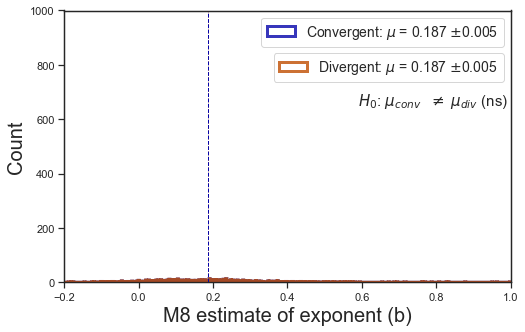

In [262]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (8, 5))
sns.distplot(corrected_conv_b, color = 'xkcd:royal blue', kde = False, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 600)
ax1.set_ylabel('Count', fontsize=20)
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 1000)
ax1.set_xlabel(str(method) + ' estimate of exponent (b)', fontsize = 20)
ax1.legend(['Convergent: $\mu$ = '+str(np.round(mean_conv,3))+' $\pm$'+str(np.round(conv_standard_error,3))],
           bbox_to_anchor=(0.5, 0.6, 0.5, 0.4),fontsize = 14)
ax1.set_xlim(-0.2, 1)
ax2 = ax1.twinx()
ax2.set_ylim(0, 1000)
ax2.set_xlim(-0.2, 1)
ax2.axes.yaxis.set_visible(False)
sns.distplot(corrected_div_b,  color='xkcd:burnt orange', kde = False,hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 600)
#ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['Divergent: $\mu$ = '+str(np.round(mean_div,3))+' $\pm$'+str(np.round(div_standard_error,3))],
           bbox_to_anchor=(0.5, 0.47, 0.5, 0.4),fontsize = 14)
plt.axvline(x=mean_div, linewidth=1, color = 'xkcd:burnt orange', alpha = 1, linestyle = '--')
plt.axvline(x=mean_conv, linewidth=1, color = 'xkcd:royal blue', alpha = 1, linestyle = '--')
ax1.text(0.59, 650, r'$H_0$: $\mu_{conv}$  $\neq$ $\mu_{div}$ ' + b_significance, fontsize=15, rotation = 0)

#plt.title('Estimate of exponent (b)', fontsize = 12)

Text(0.065, 650, '$H_0$: $\\mu_{conv}$  $\\neq$ $\\mu_{div}$ (ns)')

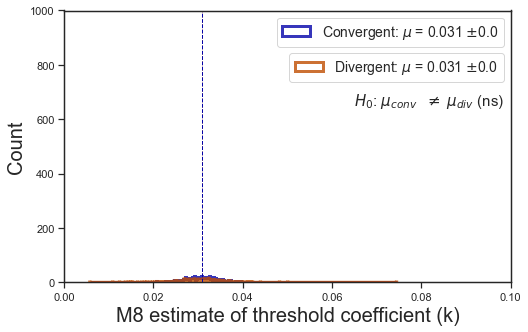

In [263]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (8, 5))
sns.distplot(corrected_conv_k, color = 'xkcd:royal blue', kde = False, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 400)
ax1.set_ylabel('Count', fontsize=20)
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 1000)
ax1.set_xlabel(str(method) + ' estimate of threshold coefficient (k)', fontsize = 20)
ax1.legend(['Convergent: $\mu$ = '+str(np.round(mean_conv_int, 3))+' $\pm$'+str(np.round(conv_standard_error_int, 3))],
           bbox_to_anchor=(0.5, 0.6, 0.5, 0.4),fontsize = 14)
ax1.set_xlim(0, .1)
ax2 = ax1.twinx()
ax2.set_ylim(0, 1000)
ax2.set_xlim(0, .1)
ax2.axes.yaxis.set_visible(False)
sns.distplot(corrected_div_k,  color='xkcd:burnt orange', kde = False,hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 900)
#ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['Divergent: $\mu$ = '+str(np.round(mean_div_int,3))+' $\pm$'+str(np.round(div_standard_error_int, 3))],
           bbox_to_anchor=(0.5, 0.47, 0.5, 0.4),fontsize = 14)
plt.axvline(x=mean_div_int, linewidth=1, color = 'xkcd:burnt orange', alpha = 1, linestyle = '--')
plt.axvline(x=mean_conv_int, linewidth=1, color = 'xkcd:royal blue', alpha = 1, linestyle = '--')
ax1.text(0.065, 650, r'$H_0$: $\mu_{conv}$  $\neq$ $\mu_{div}$ '+ k_significance, fontsize=15, rotation = 0)
#plt.title('Estimate of exponent (b)', fontsize = 12)

In [264]:
np.round(div_standard_error_int, 4)

0.0001

In [265]:
#divergent_gully = random.choice(d_list)
divergent_gully = 62358126
divergent_gully_2 = 61694828
gully_sample = random.sample(c_list, 20)
gully_sample.append(divergent_gully)
gully_sample.append(divergent_gully_2)
sample_gullies = pd.DataFrame(gully_sample) 
sample_gullies.rename(columns={0: 'node_id'}, inplace=True)
gully_sample_set = pd.merge(sample_gullies, all_data_1m_dataframe, on=['node_id'], how='inner')


In [266]:
gully_sample_set['DC'].iloc[21] = 2


C:\Users\sjwal\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [267]:
method = 'M4'

In [268]:
gully_sample_set['log_area'] = np.log10(gully_sample_set[method])
gully_sample_set['log_slope'] = np.log10(gully_sample_set['SA'])
test_m = ols('log_slope ~ log_area',gully_sample_set).fit()
test_intercept = test_m.params[0]
test_slope = test_m.params[1]

In [269]:
above_model_line = []
for i in range(0, len(gully_sample_set)):
    measured_slope = gully_sample_set['log_slope'].iloc[i]
    model_slope = test_slope * gully_sample_set['log_area'].iloc[i] + test_intercept
    if  measured_slope > model_slope:
        above_model_line.append(i)
    else:
        pass    

In [270]:
corrected_set = gully_sample_set.drop(above_model_line, axis='index')

In [271]:
lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
l_intercept = lowest_points_m.params[0]
l_slope = lowest_points_m.params[1]

In [272]:
index_position_list = []
for index, row in corrected_set.iterrows():
    index_position_list.append(index)


In [273]:
above_second_model_line = []
for i in range(0, len(corrected_set)):
    measured_slope = corrected_set['log_slope'].iloc[i]
    model_slope = l_slope * corrected_set['log_area'].iloc[i] + l_intercept
    if  measured_slope > model_slope:
        above_second_model_line.append(index_position_list[i])
    else:
        pass
    

In [274]:
corrected_set_2 = corrected_set.drop(above_second_model_line, axis='index')

In [275]:
corrected_set_2

,node_id,D4,D8,Dinf,M4,M8,DC,Slope,SA,Resolution,Flow,log_area,log_slope
1,20424627,0.1613,0.7896,0.705575,0.663406,0.491766,0,0.043946,0.021020,1,223,-0.178220,-1.677377
11,59434955,0.1419,0.4499,0.432867,0.306167,0.356429,0,0.032435,0.023206,1,223,-0.514041,-1.634402
12,17249564,2.8300,0.0006,0.810760,2.462135,1.605714,0,0.030689,0.006667,1,223,0.391312,-2.176040


## Write the estimated slope and intercept parameters to variables.
Note: The returned intercept will be in log10(a) form so we need to take the exponential $10^{k}$ to get back to the non-log10 value of the assumed function $s \geq kA^{-b}$.

In [276]:
second_lowest_points_m = ols('log_slope ~ log_area',corrected_set_2).fit()
sl_intercept = second_lowest_points_m.params[0]
sl_slope = second_lowest_points_m.params[1]

In [277]:
print('All data intercept: ', 10**test_intercept)
print('All data slope: ', test_slope * -1)

All data intercept:  0.0314829388874
All data slope:  0.337375008516


In [278]:
print('Lowest data intercept: ', 10**l_intercept)
print('Lowest data slope: ', l_slope * -1)

Lowest data intercept:  0.0189459883817
Lowest data slope:  0.489376225811


In [279]:
print('Second lowest data intercept: ', 10**sl_intercept)
print('Second lowest data slope: ', sl_slope * -1)

Second lowest data intercept:  0.0128163825127
Second lowest data slope:  0.62763069534


## Second model can either be l_slope or sl_slope.

In [280]:
generate_area_values = np.arange(0.2, 10, 0.00001)
model_slope = (10**test_intercept) * generate_area_values**(test_slope)
model_slope_alt = (10**sl_intercept) * generate_area_values**(sl_slope)
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: method}, inplace=True)

## Reshape the slope array so we can put it into a pandas dataframe.

In [281]:
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: 'SA'}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3

In [282]:
reshaped_model_slope_alt = model_slope_alt.reshape(-1,1)
df_model_slope_alt = pd.DataFrame(reshaped_model_slope_alt)
df_model_slope_alt.rename(columns={0: 'SA'}, inplace=True)
df_model_alt = pd.concat([df_model_slope_alt, df_model_area], axis=1, sort=False)
df_model_alt['DC'] = 4

In [283]:
gully_sample_set['Size'] = 1000
df_model['Size'] = 1
df_model_alt['Size'] = 1
df_all_1 = df_model.append(df_model_alt)
df_all_2 = df_all_1.append(gully_sample_set)

In [284]:
gully_sample_set

,node_id,D4,D8,Dinf,M4,M8,DC,Slope,SA,Resolution,Flow,log_area,log_slope,Size
0,27718461,0.0143,0.3981,0.397849,0.275426,0.293550,0,0.044186,0.049218,1,223,-0.559995,-1.307878,1000
1,20424627,0.1613,0.7896,0.705575,0.663406,0.491766,0,0.043946,0.021020,1,223,-0.178220,-1.677377,1000
2,25504396,0.5774,0.4769,0.546504,0.527664,0.521903,0,0.056190,0.052636,1,223,-0.277642,-1.278715,1000
3,25815829,0.5742,1.0246,1.104974,1.026683,0.622080,0,0.042416,0.032840,1,223,0.011436,-1.483591,1000
4,31711833,0.4634,0.0874,0.172455,0.258002,0.282927,0,0.041730,0.038220,1,223,-0.588377,-1.417709,1000
5,62794131,0.0023,22.0751,22.088686,10.974792,15.353873,0,0.029851,0.022314,1,223,1.040396,-1.651431,1000
6,21230658,1.8683,2.0392,1.791337,1.382780,1.371613,0,0.050453,0.027037,1,223,0.140753,-1.568035,1000
7,18640640,1.2579,0.2248,0.271338,0.592445,0.390738,0,0.036621,0.052233,1,223,-0.227352,-1.282058,1000
8,16014084,0.2714,0.0030,0.192702,0.455302,0.285024,0,0.041768,0.042104,1,223,-0.341701,-1.375679,1000
9,52007747,0.1275,1.8609,3.054549,0.663644,1.131070,0,0.037095,0.037840,1,223,-0.178065,-1.422047,1000


In [285]:
df_all_2

,SA,M4,DC,Size,node_id,D4,D8,Dinf,M8,Slope,Resolution,Flow,log_area,log_slope
0,0.054186,0.200000,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.054185,0.200010,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.054185,0.200020,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.054184,0.200030,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.054183,0.200040,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0.052714,0.317375,0,1000,43542606.0,0.7135,0.5051,0.392500,0.273478,0.049220,1.0,223.0,-0.498428,-1.278077
18,0.040630,0.538127,0,1000,15196215.0,0.9670,0.1149,0.382868,0.697569,0.055623,1.0,223.0,-0.269115,-1.391149
19,0.048236,0.615909,0,1000,38344316.0,0.5117,0.5860,0.556803,0.581561,0.039075,1.0,223.0,-0.210484,-1.316628
20,0.031095,4.734601,1,1000,62358126.0,6.8406,6.8139,7.328270,6.335984,0.040167,1.0,259.0,0.675283,-1.507310


No handles with labels found to put in legend.


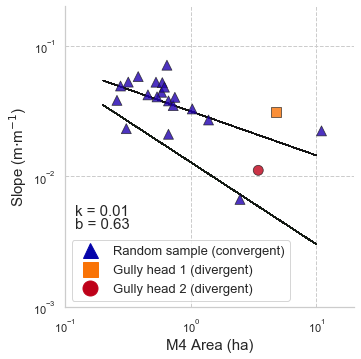

In [286]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_2
colours = {0:'xkcd:ultramarine', 1:'xkcd:orange', 2:'xkcd:scarlet', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = method
x_axis_label = x_axis + ' Area (ha)'
y_axis = 'SA'
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^','s', 'o', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.1, 20))
fig.set(ylim = (0.001, 0.2))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:royal blue', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)

ax.text(0.12, 0.005,'k = ' + str(np.round(10**sl_intercept, 2)), fontsize=15) 
ax.text(0.12, 0.004,'b = ' + str(np.round(sl_slope*-1, 2)), fontsize=15)  

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(5,5)

## End of this section. Below is stuff that I think is duplicated in other notebooks.

NameError: name 'gsc' is not defined

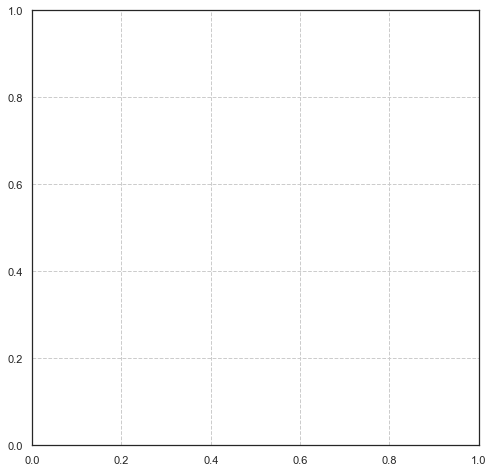

In [287]:
fig, ax = plt.subplots(figsize = (8, 8))
g0 = sns.scatterplot(x="M8", y="SA", marker = 'x', edgecolor= 'xkcd:royal blue', legend = False, 
                     linewidth = 1,data=gsc)
g1 = sns.scatterplot(x="M8", y="SA", marker = 'o',alpha=0.4, color='xkcd:orange', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = '',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
#plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:apricot')
#ax.set_ylim(-0.1,2)
#ax.set_xlim(-0.1,2)

In [288]:
corr_1m_divergent = all_data_1m.loc[(all_data_1m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_1m_convergent = all_data_1m.loc[(all_data_1m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_2m_divergent = all_data_2m.loc[(all_data_2m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_2m_convergent = all_data_2m.loc[(all_data_2m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_3m_divergent = all_data_3m.loc[(all_data_3m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_3m_convergent = all_data_3m.loc[(all_data_3m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_4m_divergent = all_data_4m.loc[(all_data_4m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_4m_convergent = all_data_4m.loc[(all_data_4m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_5m_divergent = all_data_5m.loc[(all_data_5m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_5m_convergent = all_data_5m.loc[(all_data_5m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

In [289]:
corr_1m_divergent

,D4,D8,Dinf,M4,M8,SA
D4,1.000000,0.561744,0.476232,0.920948,0.711853,-0.061860
D8,0.561744,1.000000,0.962689,0.634685,0.728168,-0.044816
Dinf,0.476232,0.962689,1.000000,0.585034,0.770414,-0.047999
M4,0.920948,0.634685,0.585034,1.000000,0.852839,-0.071035
M8,0.711853,0.728168,0.770414,0.852839,1.000000,-0.084463
SA,-0.061860,-0.044816,-0.047999,-0.071035,-0.084463,1.000000


In [290]:
corr_1m_convergent

,D4,D8,Dinf,M4,M8,SA
D4,1.000000,0.836853,0.838524,0.939502,0.820455,0.080459
D8,0.836853,1.000000,0.995597,0.933564,0.979784,-0.004036
Dinf,0.838524,0.995597,1.000000,0.935794,0.984131,0.009722
M4,0.939502,0.933564,0.935794,1.000000,0.921194,0.061545
M8,0.820455,0.979784,0.984131,0.921194,1.000000,0.049680
SA,0.080459,-0.004036,0.009722,0.061545,0.049680,1.000000


In [291]:
corr_2m_divergent

,D4,D8,Dinf,M4,M8,SA
D4,1.000000,0.581810,0.569449,0.963592,0.565151,-0.153961
D8,0.581810,1.000000,0.950174,0.575015,0.757197,-0.183071
Dinf,0.569449,0.950174,1.000000,0.584548,0.865771,-0.178316
M4,0.963592,0.575015,0.584548,1.000000,0.617132,-0.172674
M8,0.565151,0.757197,0.865771,0.617132,1.000000,-0.216519
SA,-0.153961,-0.183071,-0.178316,-0.172674,-0.216519,1.000000


In [292]:
corr_1m_convergent

,D4,D8,Dinf,M4,M8,SA
D4,1.000000,0.836853,0.838524,0.939502,0.820455,0.080459
D8,0.836853,1.000000,0.995597,0.933564,0.979784,-0.004036
Dinf,0.838524,0.995597,1.000000,0.935794,0.984131,0.009722
M4,0.939502,0.933564,0.935794,1.000000,0.921194,0.061545
M8,0.820455,0.979784,0.984131,0.921194,1.000000,0.049680
SA,0.080459,-0.004036,0.009722,0.061545,0.049680,1.000000


[Text(0, 0.5, 'D4'),
 Text(0, 1.5, 'D8'),
 Text(0, 2.5, 'Dinf'),
 Text(0, 3.5, 'M4'),
 Text(0, 4.5, 'M8'),
 Text(0, 5.5, 'SA')]

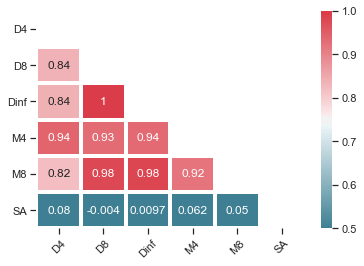

In [293]:
sns.set(style = 'ticks')

data = corr_1m_convergent

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=data.columns, mask=mask,
                         yticklabels=data.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

[Text(0, 0.5, 'D4'),
 Text(0, 1.5, 'D8'),
 Text(0, 2.5, 'Dinf'),
 Text(0, 3.5, 'M4'),
 Text(0, 4.5, 'M8'),
 Text(0, 5.5, 'SA')]

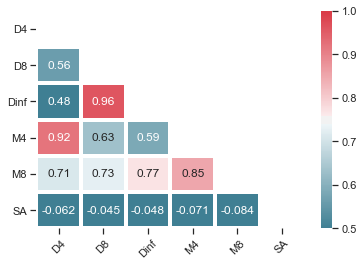

In [294]:
sns.set(style = 'ticks')

data = corr_1m_divergent

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=data.columns, mask=mask,
                         yticklabels=data.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [295]:
correlation_dict_convergent = {}
correlation_dict_divergent = {}

In [296]:

correlation_dict_convergent['D4-M8'] = [corr_1m_convergent.iloc[4,0], 
                             corr_2m_convergent.iloc[4,0], corr_3m_convergent.iloc[4,0], 
                             corr_4m_convergent.iloc[4,0], corr_5m_convergent.iloc[4,0]]

correlation_dict_convergent['D8-M8'] = [corr_1m_convergent.iloc[4,1], 
                             corr_2m_convergent.iloc[4,1], corr_3m_convergent.iloc[4,1], 
                             corr_4m_convergent.iloc[4,1], corr_5m_convergent.iloc[4,1]]

correlation_dict_convergent['Dinf-M8'] = [corr_1m_convergent.iloc[4,2], 
                               corr_2m_convergent.iloc[4,2], corr_3m_convergent.iloc[4,2], 
                               corr_4m_convergent.iloc[4,2], corr_5m_convergent.iloc[4,2]]
correlation_dict_convergent['M4-M8'] = [corr_1m_convergent.iloc[4,3], 
                             corr_2m_convergent.iloc[4,3], corr_3m_convergent.iloc[4,3], 
                             corr_4m_convergent.iloc[4,3], corr_5m_convergent.iloc[4,3]]

correlation_dict_divergent['D4-M8'] = [corr_1m_divergent.iloc[4,0], 
                             corr_2m_divergent.iloc[4,0], corr_3m_divergent.iloc[4,0], 
                             corr_4m_divergent.iloc[4,0], corr_5m_divergent.iloc[4,0]]

correlation_dict_divergent['D8-M8'] = [corr_1m_divergent.iloc[4,1], 
                             corr_2m_divergent.iloc[4,1], corr_3m_divergent.iloc[4,1], 
                             corr_4m_divergent.iloc[4,1], corr_5m_divergent.iloc[4,1]]

correlation_dict_divergent['Dinf-M8'] = [corr_1m_divergent.iloc[4,2], 
                               corr_2m_divergent.iloc[4,2], corr_3m_divergent.iloc[4,2], 
                               corr_4m_divergent.iloc[4,2], corr_5m_divergent.iloc[4,2]]
correlation_dict_divergent['M4-M8'] = [corr_1m_divergent.iloc[4,3], 
                             corr_2m_divergent.iloc[4,3], corr_3m_divergent.iloc[4,3], 
                             corr_4m_divergent.iloc[4,3], corr_5m_divergent.iloc[4,3]]

In [297]:
correlation_convergent_dataframe = pd.DataFrame.from_dict(correlation_dict_convergent, orient='index')
correlation_divergent_dataframe = pd.DataFrame.from_dict(correlation_dict_divergent, orient='index')
    

In [298]:
correlation_convergent_dataframe.columns = ['1m', '2m', '3m', '4m', '5m']
correlation_divergent_dataframe.columns = ['1m', '2m', '3m', '4m', '5m']

In [299]:
correlation_convergent_dataframe['Comparison'] = correlation_convergent_dataframe.index
correlation_divergent_dataframe['Comparison'] = correlation_divergent_dataframe.index

In [300]:
melted_convergent_correlations = pd.melt(correlation_convergent_dataframe, id_vars=['Comparison'], var_name='Resolution')
convergent_correlations = melted_convergent_correlations.rename(columns={'value': 'Correlation'})

melted_divergent_correlations = pd.melt(correlation_divergent_dataframe, id_vars=['Comparison'], var_name='Resolution')
divergent_correlations = melted_divergent_correlations.rename(columns={'value': 'Correlation'})

In [301]:
from matplotlib.lines import Line2D

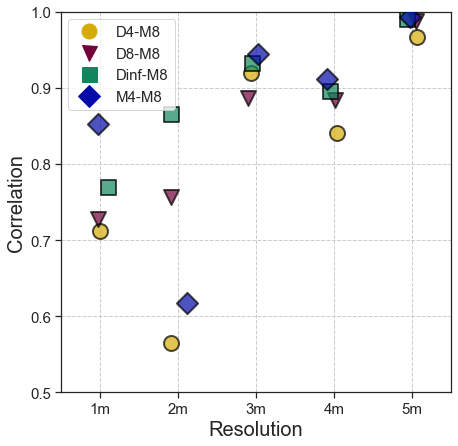

In [304]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (7, 7))
jitter = 0.15
data = divergent_correlations
ylim_min = .5
ylim_max = 1
#plt.clf()
D4p = data[(data['Comparison']=='D4-M8')]
colors = ['burnt yellow']
m = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='o',data=D4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))
D8p = data[(data['Comparison']=='D8-M8')]
colors = ['merlot']
n = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Comparison']=='Dinf-M8')]
colors = ['dark sea green']
o = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Comparison']=='M4-M8')]
colors = ['cobalt blue']
p = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4-M8')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8-M8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf-M8')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4-M8')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Algorithm comparisons',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D4l, D8l, Dinfl,M4l],fontsize=15)


# With no D4

In [307]:
divergent_correlations_no_D4 = divergent_correlations.drop([0, 4, 8, 12, 16])

In [319]:
divergent_correlations_no_D4

,Comparison,Resolution,Correlation
1,D8-M8,1m,0.728168
2,Dinf-M8,1m,0.770414
3,M4-M8,1m,0.852839
5,D8-M8,2m,0.757197
6,Dinf-M8,2m,0.865771
7,M4-M8,2m,0.617132
9,D8-M8,3m,0.886083
10,Dinf-M8,3m,0.932845
11,M4-M8,3m,0.944233
13,D8-M8,4m,0.883972


In [315]:
convergent_correlations_no_D4 = convergent_correlations.drop([0, 4, 8, 12, 16])

In [318]:
convergent_correlations_no_D4

,Comparison,Resolution,Correlation
1,D8-M8,1m,0.979784
2,Dinf-M8,1m,0.984131
3,M4-M8,1m,0.921194
5,D8-M8,2m,0.951026
6,Dinf-M8,2m,0.959349
7,M4-M8,2m,0.983786
9,D8-M8,3m,0.857372
10,Dinf-M8,3m,0.923219
11,M4-M8,3m,0.940928
13,D8-M8,4m,0.918404


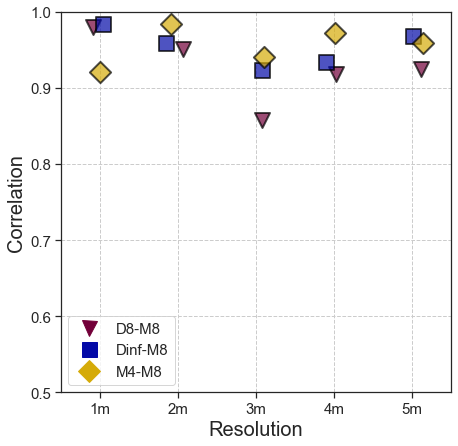

In [317]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (7, 7))
jitter = 0.15
data = convergent_correlations_no_D4
ylim_min = .5
ylim_max = 1
#plt.clf()

D8p = data[(data['Comparison']=='D8-M8')]
colors = ['merlot']
n = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Comparison']=='Dinf-M8')]
colors = ['cobalt blue']
o = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Comparison']=='M4-M8')]
colors = ['burnt yellow']
p = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8-M8')
Dinfl = Line2D([], [], color='xkcd:cobalt blue', marker='s', linestyle='None',
                          markersize=15, label='Dinf-M8')
M4l = Line2D([], [], color='xkcd:burnt yellow', marker='D', linestyle='None',
                          markersize=15, label='M4-M8')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Algorithm comparisons',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D8l, Dinfl,M4l],fontsize=15)


In [320]:
exponent_b_divergent = pd.read_excel('exponent_b_divergent.xlsx')
exponent_b_divergent['Flow'] = 'Divergent'
exponent_b_convergent = pd.read_excel('exponent_b_convergent.xlsx')
exponent_b_convergent['Flow'] = 'Convergent'

In [321]:
d4_mean = np.mean([exponent_b_convergent['D4'].to_numpy(),exponent_b_divergent['D4'].to_numpy()], axis = 0)
d8_mean = np.mean([exponent_b_convergent['D8'].to_numpy(),exponent_b_divergent['D8'].to_numpy()], axis = 0)
dinf_mean = np.mean([exponent_b_convergent['Dinf'].to_numpy(),exponent_b_divergent['Dinf'].to_numpy()], axis = 0)
m4_mean = np.mean([exponent_b_convergent['M4'].to_numpy(),exponent_b_divergent['M4'].to_numpy()], axis = 0)
m8_mean = np.mean([exponent_b_convergent['M8'].to_numpy(),exponent_b_divergent['M8'].to_numpy()], axis = 0)

In [322]:
exponent_b_mean = exponent_b_divergent.copy()

In [323]:
exponent_b_mean['D4'] = d4_mean
exponent_b_mean['D8'] = d8_mean
exponent_b_mean['Dinf'] = dinf_mean
exponent_b_mean['M4'] = m4_mean
exponent_b_mean['M8'] = m8_mean

In [324]:
mean_dataframe = pd.melt(exponent_b_mean, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'b')

In [325]:
flow_datasets = [exponent_b_convergent, exponent_b_divergent]

In [326]:
conv_and_div = pd.concat(flow_datasets)

In [327]:
conv_dataframe = pd.melt(exponent_b_convergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'b')

In [328]:
div_dataframe = pd.melt(exponent_b_divergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'b')

In [329]:
scalar_k_divergent = pd.read_excel('scalar_k_divergent.xlsx')
scalar_k_divergent['Flow'] = 'Divergent'
scalar_k_convergent = pd.read_excel('scalar_k_convergent.xlsx')
scalar_k_convergent['Flow'] = 'Convergent'

In [330]:
flow_datasets_k = [scalar_k_convergent, scalar_k_divergent]
conv_and_div_k = pd.concat(flow_datasets_k)

In [331]:
conv_dataframe_k = pd.melt(scalar_k_convergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'k')

In [332]:
div_dataframe_k = pd.melt(scalar_k_divergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'k')

Text(0.5, 1.0, 'Divergent')

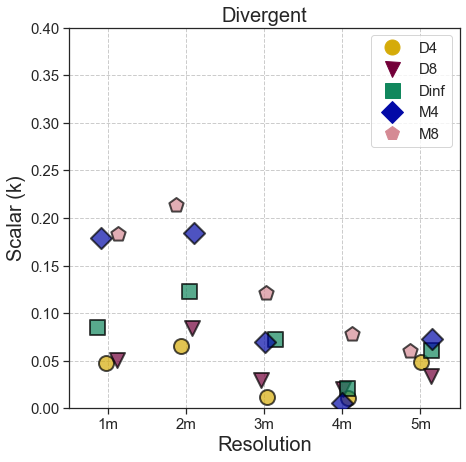

In [338]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (7, 7))
jitter = 0.15
parameter = 'k'
data = div_dataframe_k
ylim_min = 0
ylim_max = .05
#plt.clf()
D4p = data[(data['Method']=='D4')]
colors = ['burnt yellow']
m = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='o',data=D4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))
D8p = data[(data['Method']=='D8')]
colors = ['merlot']
n = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Method']=='Dinf')]
colors = ['dark sea green']
o = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Method']=='M4')]
colors = ['cobalt blue']
p = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M8p = data[(data['Method']=='M8')]
colors = ['dusty pink']
p = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='p',data=M8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4')
M8l = Line2D([], [], color='xkcd:dusty pink', marker='p', linestyle='None',
                          markersize=15, label='M8')


ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Scalar (k)', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D4l, D8l, Dinfl,M4l,M8l],fontsize=15)
plt.title('Divergent', fontsize = 20)

# With no D4

In [342]:
div_dataframe_k_no_D4 = div_dataframe_k.drop([0, 1, 2, 3, 4])
conv_dataframe_k_no_D4 = conv_dataframe_k.drop([0, 1, 2, 3, 4])
div_dataframe_no_D4 = div_dataframe.drop([0, 1, 2, 3, 4])
conv_dataframe_no_D4 = conv_dataframe.drop([0, 1, 2, 3, 4])

Text(0.5, 1.0, 'Divergent')

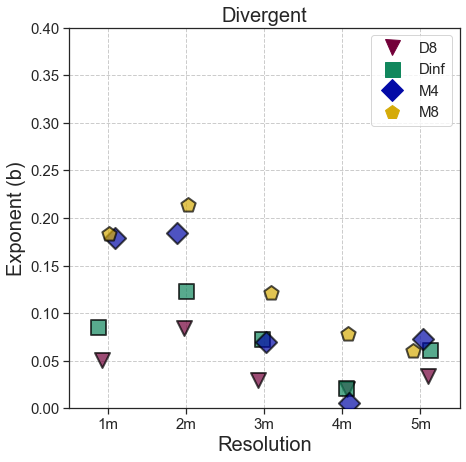

In [357]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (7, 7))
jitter = 0.15
parameter = 'b'
data = div_dataframe_no_D4
ylim_min = 0
ylim_max = .4
#plt.clf()

D8p = data[(data['Method']=='D8')]
colors = ['merlot']
n = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Method']=='Dinf')]
colors = ['dark sea green']
o = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Method']=='M4')]
colors = ['cobalt blue']
p = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M8p = data[(data['Method']=='M8')]
colors = ['burnt yellow']
p = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='p',data=M8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4')
M8l = Line2D([], [], color='xkcd:burnt yellow', marker='p', linestyle='None',
                          markersize=15, label='M8')


ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Exponent (b)', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D8l, Dinfl,M4l,M8l],fontsize=15)
plt.title('Divergent', fontsize = 20)

NameError: name 'conv_and_div_dataframe' is not defined

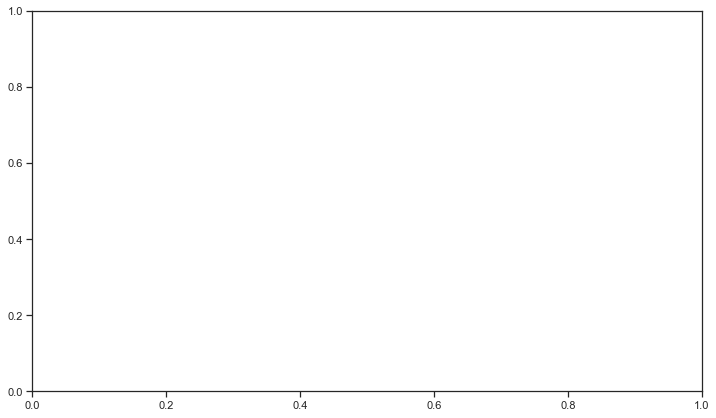

In [358]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (12, 7))
jitter = 0.15
data = conv_and_div_dataframe
ylim_min = 0
ylim_max = .4
#plt.clf()
D4p = data[(data['Method']=='D4')]
m = sns.stripplot('Resolution','b',
                  marker='o',data=D4p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))

D8p = data[(data['Method']=='D8')]
n = sns.stripplot('Resolution','b',
                  marker='v',data=D8p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Method']=='Dinf')]
o = sns.stripplot('Resolution','b',
                  marker='s',data=Dinfp, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Method']=='M4')]
p = sns.stripplot('Resolution','b',
                  marker='D',data=M4p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M8p = data[(data['Method']=='M8')]
p = sns.stripplot('Resolution','b',
                  marker='p',data=M8p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4')
M8l = Line2D([], [], color='xkcd:dusty pink', marker='p', linestyle='None',
                          markersize=15, label='M8')


ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Algorithm comparisons',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D4l, D8l, Dinfl,M4l,M8l],fontsize=15)


In [359]:
j = all_data_1m.loc[(all_data_1m['DC'] == 1)].drop(columns = ['node_id', 'Slope', 'Resolution'])

In [360]:
r = all_data_1m[all_data_1m.DC != 'not enough grid cells'].drop(columns = ['node_id', 'Slope', 'Resolution'])

C:\Users\sjwal\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [361]:
r

,D4,D8,Dinf,M4,M8,DC,SA
6369407,0.7936,0.4192,0.432222,0.584626,0.481259,0,0.044079
8000074,0.5183,0.9929,1.024181,0.900704,0.962416,1,0.040577
8402506,0.5654,0.5344,0.504951,0.546750,0.482315,0,0.056838
9130277,0.8072,0.7289,0.728331,0.757537,0.464273,0,0.022517
9183765,0.4843,0.8293,0.723900,0.759752,0.470430,0,0.040390
...,...,...,...,...,...,...,...
62794131,0.0023,22.0751,22.088686,10.974792,15.353873,0,0.022314
64129981,0.1730,0.0239,0.186611,0.294549,0.289628,1,0.012048
65836953,2.1117,1.8009,1.801514,1.964746,1.910864,1,0.032858
66631077,1.4384,1.5663,1.529028,1.505315,1.519280,1,0.033483


In [362]:
dr = r.drop(['SA'], axis=1).rename(columns = {'D4': 'D4 (ha)', 'D8': 'D8 (ha)', 'Dinf': 'Dinf (ha)',
                                             'M4': 'M4 (ha)', 'M8': 'M8 (ha)'}, inplace = False)

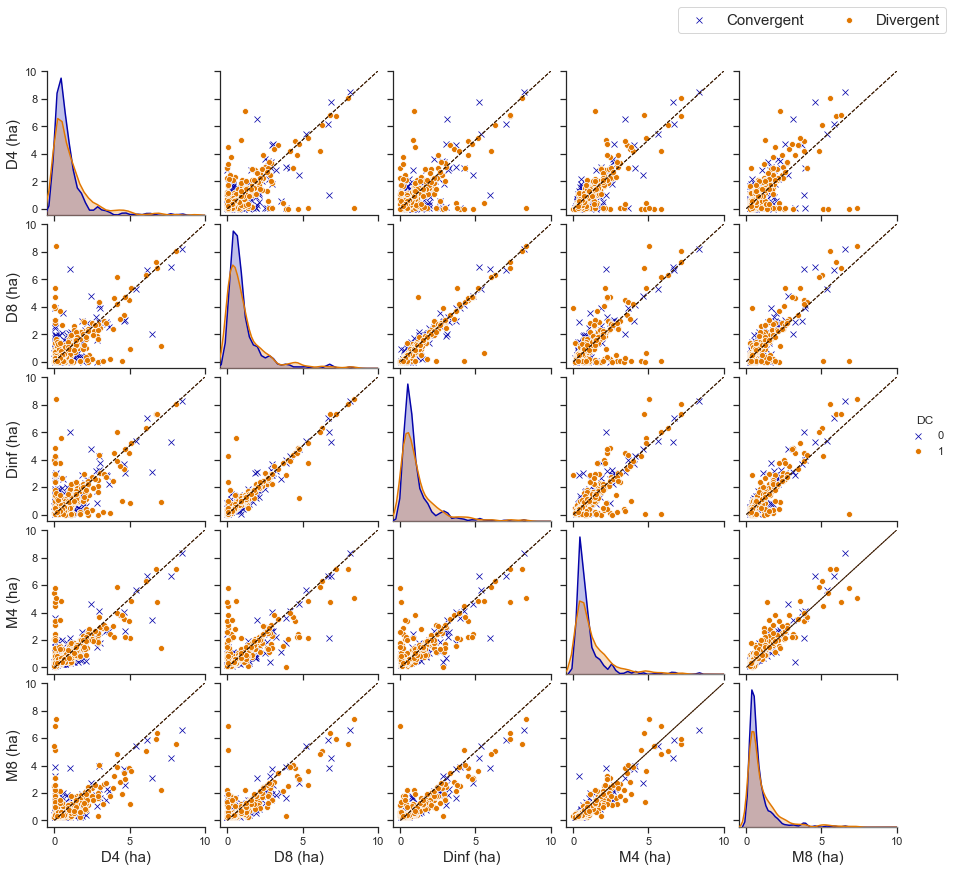

In [363]:

sns.set(style = "ticks")
colors = ["xkcd:royal blue", "xkcd:pumpkin"]
data = dr
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color = 'xkcd:chocolate', marker=None,
            linestyle='--', linewidth=1.0)

fig = sns.pairplot(data, palette = colors, hue = 'DC', markers=['x', 'o'])

handles = fig._legend_data.values()
labels = ['Convergent', 'Divergent']

fig.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3, fontsize = 15)
fig.fig.subplots_adjust(top=0.92, bottom=0.08)

sns.plotting_context()
fig.map_offdiag(plot_unity)

fig.set(ylim=(-0.5,10))
fig.set(xlim=(-0.5,10))
plt.rcParams["axes.labelsize"] = 15
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    m = ax.get_ylabel()
    ax.set_xlabel(l, fontsize=15)
    ax.set_ylabel(m, fontsize=15)

NameError: name 'merge_correlation_means' is not defined

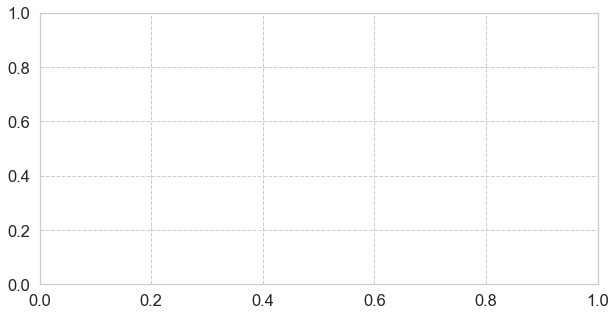

In [364]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize = (10, 5))
data = merge_correlation_means
colors = ['xkcd:pumpkin', 'xkcd:very light blue']
# Draw a nested barplot to show survival for class and sex

sns.barplot(x="Method", y="Correlation", hue="Flow", data=data,
                  palette=colors, alpha = 0.8,linewidth=2,edgecolor="black",)

ax.set_ylabel("Correlation", fontsize = 20)
ax.set_xlabel("Routing method", fontsize = 20)
ax.set(ylim = (0.2, 1))

#fig.set_xlabel("X Label",fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='15')
#ax.set_yticklabels(ax.get_yticks(), size = 15)

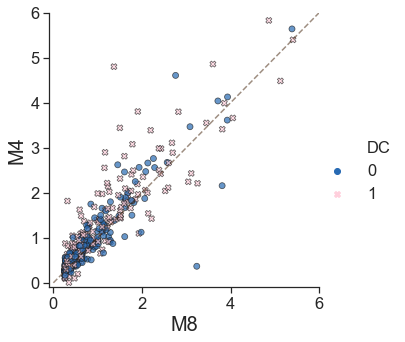

In [365]:
sns.set_style('ticks', {'grid.linestyle': '--'})
data = r
colours = {0:'xkcd:mid blue', 1:'xkcd:pale pink'}
x_axis = 'M8'
y_axis = 'M4'
fig = sns.relplot(x=x_axis, y=y_axis, palette = colours, hue = 'DC',
                 data=data, alpha = 0.7, legend = 'brief', edgecolor="k", style = 'DC')

ax = fig.axes[0,0]
ax.set_xlim(-0.1,6)
ax.set_ylim(-0.1,6)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:chocolate', alpha = 0.5)

In [366]:
frames = [all_data_1m_dataframe, all_data_2m_dataframe, 
          all_data_3m_dataframe, all_data_4m_dataframe, 
          all_data_5m_dataframe]

In [367]:
all_resolutions = pd.concat(frames)

In [368]:
all_resolutions

,D4,D8,Dinf,M4,M8,node_id,DC,Slope,SA,Resolution,Flow
8000074,0.5183,0.9929,1.024181,0.900704,0.962416,8000074,1,0.043282,0.040577,1,259
9172835,0.2330,0.7025,0.673875,0.676058,0.665612,9172835,1,0.059411,0.010373,1,259
9370420,1.2351,1.2773,0.801749,1.262353,0.812412,9370420,1,0.044611,0.028332,1,259
9956490,0.5578,0.4186,0.420061,0.436668,0.426981,9956490,1,0.025017,0.032782,1,259
10217375,1.1357,0.7424,0.774059,0.437948,0.562779,10217375,1,0.016057,0.011424,1,259
...,...,...,...,...,...,...,...,...,...,...,...
2468910,0.4850,0.1575,0.200191,0.321723,0.848876,2468910,0,0.028704,0.016786,5,426
2477512,5.0700,3.1275,4.247647,3.211978,3.910798,2477512,0,0.036064,0.025436,5,426
2564530,0.9075,0.1225,0.520357,0.613144,0.283214,2564530,0,0.023924,0.024667,5,426
2634112,2.4650,2.0425,2.027472,2.151062,1.641589,2634112,0,0.039369,0.046443,5,426


In [386]:
gully_head_dataframe = pd.melt(all_resolutions, id_vars=['node_id', 'DC', 'Slope', 'Resolution', 'SA', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'Area')

In [387]:
gully_head_dataframe

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area
0,8000074,1,0.043282,1,0.040577,259,D4,0.518300
1,9172835,1,0.059411,1,0.010373,259,D4,0.233000
2,9370420,1,0.044611,1,0.028332,259,D4,1.235100
3,9956490,1,0.025017,1,0.032782,259,D4,0.557800
4,10217375,1,0.016057,1,0.011424,259,D4,1.135700
...,...,...,...,...,...,...,...,...
11375,2468910,0,0.028704,5,0.016786,426,M8,0.848876
11376,2477512,0,0.036064,5,0.025436,426,M8,3.910798
11377,2564530,0,0.023924,5,0.024667,426,M8,0.283214
11378,2634112,0,0.039369,5,0.046443,426,M8,1.641589


In [388]:
a = gully_head_dataframe.loc[(gully_head_dataframe['DC'] == 1)]

In [389]:
b = gully_head_dataframe.loc[(gully_head_dataframe['DC'] == 0)]

In [390]:
b.groupby(['Resolution','Method']).count()

node_id   DC  Slope   SA  Flow  Area
Resolution Method                                      
1          D4          223  223    223  223   223   223
           D8          223  223    223  223   223   223
           Dinf        223  223    223  223   223   223
           M4          223  223    223  223   223   223
           M8          223  223    223  223   223   223
2          D4          263  263    263  263   263   263
           D8          263  263    263  263   263   263
           Dinf        263  263    263  263   263   263
           M4          263  263    263  263   263   263
           M8          263  263    263  263   263   263
3          D4          347  347    347  347   347   347
           D8          347  347    347  347   347   347
           Dinf        347  347    347  347   347   347
           M4          347  347    347  347   347   347
           M8          347  347    347  347   347   347
4          D4          366  366    366  366   366   366
           D8          366  366    366  366   366   366
           Dinf        366  366    366  366   366   366
           M4          366  366    366  366   366   366
           M8          366  366    366  366   366   366
5          D4          426  426    426  426   426   426
           D8          426  426    426  426   426   426
           Dinf        426  426    426  426   426   426
           M4          426  426    426  426   426   426
           M8          426  426    426  426   426   426

In [392]:
gully_head_dataframe

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area
0,8000074,1,0.043282,1,0.040577,259,D4,0.518300
1,9172835,1,0.059411,1,0.010373,259,D4,0.233000
2,9370420,1,0.044611,1,0.028332,259,D4,1.235100
3,9956490,1,0.025017,1,0.032782,259,D4,0.557800
4,10217375,1,0.016057,1,0.011424,259,D4,1.135700
...,...,...,...,...,...,...,...,...
11375,2468910,0,0.028704,5,0.016786,426,M8,0.848876
11376,2477512,0,0.036064,5,0.025436,426,M8,3.910798
11377,2564530,0,0.023924,5,0.024667,426,M8,0.283214
11378,2634112,0,0.039369,5,0.046443,426,M8,1.641589


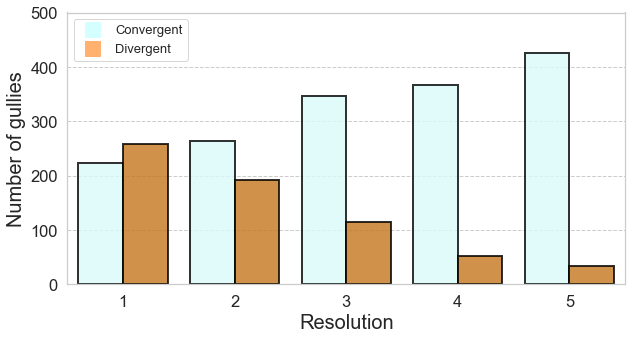

In [391]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize = (10, 5))
data = gully_head_dataframe
colors = ['xkcd:very light blue', 'xkcd:pumpkin']
# Draw a nested barplot to show survival for class and sex

sns.barplot(x="Resolution", y = 'Flow', hue="DC", data=data,
                  palette=colors, alpha = 0.8,linewidth=2,edgecolor="black",)

ax.set_ylabel("Number of gullies", fontsize = 20)
ax.set_xlabel("Resolution", fontsize = 20)
ax.set(ylim = (0, 500))

Div = Line2D([], [], color='xkcd:apricot', marker='s', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='s', linestyle='None',
                          markersize=15, label='Convergent')

#fig.set_xlabel("X Label",fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='15')

plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)

#ax.set_yticklabels(ax.get_yticks(), size = 15)


In [393]:
m8_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'M8')]

In [394]:
dinf_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'Dinf')]

In [395]:
dinf_1m_only = dinf_only.loc[(dinf_only['Resolution'] == 1)]

In [396]:
d8_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'D8')]

In [397]:
d8_1m_only = d8_only.loc[(d8_only['Resolution'] == 1)]

In [398]:
m4_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'M4')]

In [399]:
m4_1m_only = m4_only.loc[(m4_only['Resolution'] == 1)]

In [400]:
d4_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'D4')]

In [401]:
m8_1m_only = m8_only.loc[(m8_only['Resolution'] == 1)]

In [402]:
m8_2m_only = m8_only.loc[(m8_only['Resolution'] == 2)]

In [403]:
m8_3m_only = m8_only.loc[(m8_only['Resolution'] == 3)]

In [404]:
m8_4m_only = m8_only.loc[(m8_only['Resolution'] == 4)]

In [405]:
m8_5m_only = m8_only.loc[(m8_only['Resolution'] == 5)]

In [406]:
m8_only.head()

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area
9104,8000074,1,0.043282,1,0.040577,259,M8,0.962416
9105,9172835,1,0.059411,1,0.010373,259,M8,0.665612
9106,9370420,1,0.044611,1,0.028332,259,M8,0.812412
9107,9956490,1,0.025017,1,0.032782,259,M8,0.426981
9108,10217375,1,0.016057,1,0.011424,259,M8,0.562779


In [407]:
d8_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'D8')]

In [408]:
combined_multiple_direction = m8_1m_only.append(m4_1m_only)

In [409]:
m4_values = m4_1m_only.loc[:,'Area'].values
m8_values = m8_1m_only.loc[:,'Area'].values
average_values = (m4_values + m8_values) / 2
mean_multiple_flow = m4_1m_only.copy()
mean_multiple_flow['average_area'] = average_values

In [410]:
np.random.seed(8)

remove_n = 0

drop_indices = np.random.choice(d8_1m_only.index, remove_n, replace=False)
df_subset = d8_1m_only.drop(drop_indices)

In [411]:
df_subset

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area
2276,8000074,1,0.043282,1,0.040577,259,D8,0.9929
2277,9172835,1,0.059411,1,0.010373,259,D8,0.7025
2278,9370420,1,0.044611,1,0.028332,259,D8,1.2773
2279,9956490,1,0.025017,1,0.032782,259,D8,0.4186
2280,10217375,1,0.016057,1,0.011424,259,D8,0.7424
...,...,...,...,...,...,...,...,...
2753,59870384,0,0.036402,1,0.038319,223,D8,0.8039
2754,61933545,0,0.042404,1,0.021776,223,D8,3.2601
2755,62075038,0,0.046476,1,0.029066,223,D8,4.7473
2756,62794131,0,0.029851,1,0.022314,223,D8,22.0751


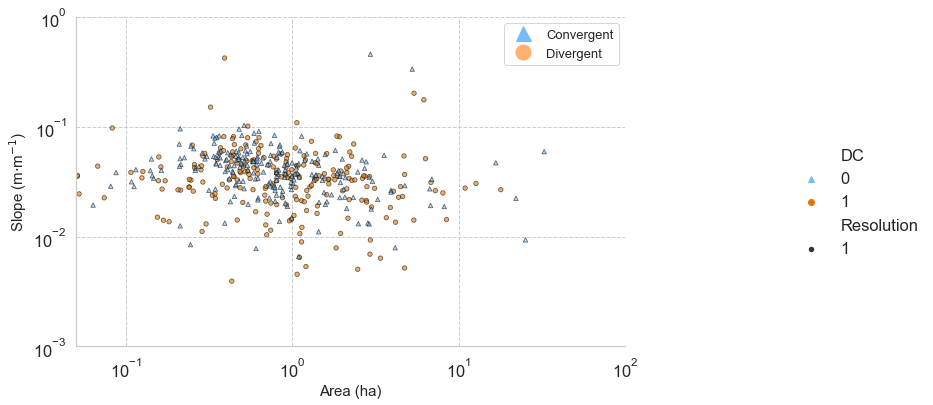

In [412]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = df_subset
colours = {0:'xkcd:sky blue', 1:'xkcd:pumpkin'}
x_axis = 'Area'
y_axis = 'SA'

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC',
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                  style = 'DC', markers=['^', 'o'], size = 'Resolution', sizes=(20,200))

ax = fig.axes[0,0]
ax.set_xlim(0.05,100)
ax.set_ylim(0.001,1)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:sky blue', marker='^', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(15,6)

In [722]:
orthogonal_regression_dataset = df_subset

In [723]:
orthogonal_regression_dataset['log_area'] = np.log10(df_subset['Area'])
orthogonal_regression_dataset['log_slope'] = np.log10(df_subset['SA'])

In [724]:
orthogonal_regression_dataset

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area,log_area,log_slope
2276,8000074,1,0.043282,1,0.040577,259,D8,0.9929,-0.003094,-1.391724
2277,9172835,1,0.059411,1,0.010373,259,D8,0.7025,-0.153354,-1.984098
2278,9370420,1,0.044611,1,0.028332,259,D8,1.2773,0.106293,-1.547728
2279,9956490,1,0.025017,1,0.032782,259,D8,0.4186,-0.378201,-1.484362
2280,10217375,1,0.016057,1,0.011424,259,D8,0.7424,-0.129362,-1.942166
...,...,...,...,...,...,...,...,...,...,...
2753,59870384,0,0.036402,1,0.038319,223,D8,0.8039,-0.094798,-1.416583
2754,61933545,0,0.042404,1,0.021776,223,D8,3.2601,0.513231,-1.662028
2755,62075038,0,0.046476,1,0.029066,223,D8,4.7473,0.676447,-1.536610
2756,62794131,0,0.029851,1,0.022314,223,D8,22.0751,1.343903,-1.651431


In [725]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.01672725 -1.46643606]
Beta Std Error: [ 0.01614509  0.0126922 ]
Beta Covariance: [[ 0.00376265  0.00097001]
 [ 0.00097001  0.00232534]]
Residual Variance: 0.06927677948163051
Inverse Condition #: 0.6959960378790234
Reason(s) for Halting:
  Sum of squares convergence


In [726]:
print('b: ', out.beta[0] *-1)
print('k: ', 10**out.beta[1])

b:  0.0167272503933
k:  0.0341636247248


In [727]:
b_orth = out.beta[0] 
k_orth = out.beta[1]

In [728]:
k_adjustment_dataset = orthogonal_regression_dataset

In [729]:
proportion_of_points_above_line = 0.95
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*proportion_of_points_above_line).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')

In [730]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [731]:
orthogonal_regression_dataset

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area,log_area,log_slope
2276,8000074,1,0.043282,1,0.040577,259,D8,0.9929,-0.003094,-1.391724
2277,9172835,1,0.059411,1,0.010373,259,D8,0.7025,-0.153354,-1.984098
2278,9370420,1,0.044611,1,0.028332,259,D8,1.2773,0.106293,-1.547728
2279,9956490,1,0.025017,1,0.032782,259,D8,0.4186,-0.378201,-1.484362
2280,10217375,1,0.016057,1,0.011424,259,D8,0.7424,-0.129362,-1.942166
...,...,...,...,...,...,...,...,...,...,...
2753,59870384,0,0.036402,1,0.038319,223,D8,0.8039,-0.094798,-1.416583
2754,61933545,0,0.042404,1,0.021776,223,D8,3.2601,0.513231,-1.662028
2755,62075038,0,0.046476,1,0.029066,223,D8,4.7473,0.676447,-1.536610
2756,62794131,0,0.029851,1,0.022314,223,D8,22.0751,1.343903,-1.651431


In [732]:
graph_data = orthogonal_regression_dataset

In [733]:
graph_data

,node_id,DC,Slope,Resolution,SA,Flow,Method,Area,log_area,log_slope
2276,8000074,1,0.043282,1,0.040577,259,D8,0.9929,-0.003094,-1.391724
2277,9172835,1,0.059411,1,0.010373,259,D8,0.7025,-0.153354,-1.984098
2278,9370420,1,0.044611,1,0.028332,259,D8,1.2773,0.106293,-1.547728
2279,9956490,1,0.025017,1,0.032782,259,D8,0.4186,-0.378201,-1.484362
2280,10217375,1,0.016057,1,0.011424,259,D8,0.7424,-0.129362,-1.942166
...,...,...,...,...,...,...,...,...,...,...
2753,59870384,0,0.036402,1,0.038319,223,D8,0.8039,-0.094798,-1.416583
2754,61933545,0,0.042404,1,0.021776,223,D8,3.2601,0.513231,-1.662028
2755,62075038,0,0.046476,1,0.029066,223,D8,4.7473,0.676447,-1.536610
2756,62794131,0,0.029851,1,0.022314,223,D8,22.0751,1.343903,-1.651431


In [734]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [735]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: 'Area'}, inplace=True)
#graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: 'SA'}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

No handles with labels found to put in legend.


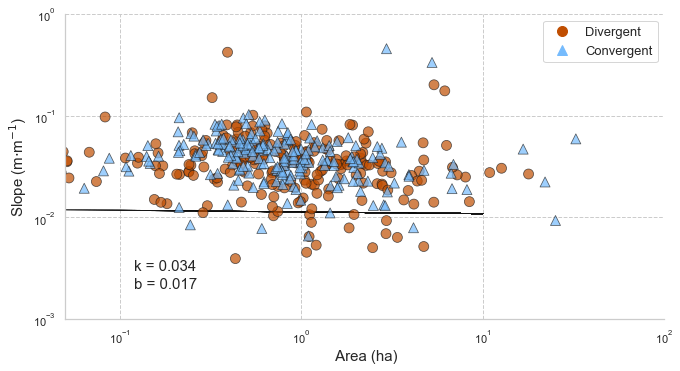

In [736]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {0:'xkcd:sky blue', 3:'xkcd:black', 1:'xkcd:burnt orange'}
x_axis = 'Area'
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = 'SA'
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.7, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', 'o', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.05, 100))
fig.set(ylim = (0.001, 1))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

g1 = Line2D([], [], color='xkcd:burnt orange', marker='o', linestyle='None',
                         markersize=10, label='Divergent')

g2 = Line2D([], [], color='xkcd:sky blue', marker='^', linestyle='None',
                          markersize=10, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[g1, g2],fontsize=13, loc=1)
#plt.legend(handles=[g1],fontsize=13, loc=1)

#ax.text(0.12, 0.4,'FPDEMS smoothed', fontsize=15) 
ax.text(0.12, 0.003,'k = ' + str(np.round(10**out.beta[1], 3)), fontsize=15) 
ax.text(0.12, 0.002,'b = ' + str(np.round(model_parameter_b, 3)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(10,5)

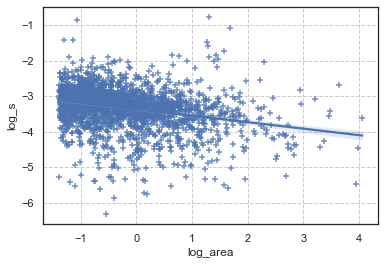

In [253]:
data = m8_only
ax = sns.regplot(x="log_area", y="log_s", data=data, marker = '+')

In [221]:
v = gully_head_dataframe.loc[(gully_head_dataframe.Resolution == 1)&(gully_head_dataframe['Method'] == 'M8')]

In [228]:
v.drop(v.loc[v['DC']=='not enough grid cells'].index, inplace=True)

C:\Users\sjwal\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
C:\Users\sjwal\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


C:\Users\sjwal\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


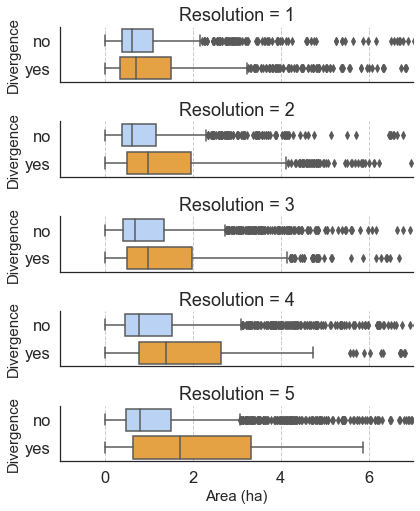

In [306]:
data = gully_head_dataframe
colours = {0:'xkcd:powder blue', 1:'xkcd:mango'}
g = sns.catplot(x="Area", y="DC", row="Resolution",
                kind="box", orient="h", height=1.5, aspect=4,
                data=data, ax = ax, palette = colours)
g.set(xlim=(-1, 7))
plt.xlabel('Area (ha)', fontsize=15)
for ax in g.axes.flat:
    ax.set_ylabel('Divergence', fontsize=15)
    ax.set(yticklabels=['no', 'yes'])
    

In [233]:
gully_head_dataframe

,node_id,DC,Slope,Resolution,SA,Method,Area
0,6369407,0,0.043334,1,0.044079,D4,0.793600
1,8000074,1,0.043282,1,0.040577,D4,0.518300
2,8402506,0,0.048987,1,0.056838,D4,0.565400
3,9130277,0,0.049699,1,0.022517,D4,0.807200
4,9183765,0,0.048443,1,0.040390,D4,0.484300
...,...,...,...,...,...,...,...
11375,2510461,1,0.008467,5,0.022358,M8,5.029630
11376,2564530,0,0.023924,5,0.024667,M8,0.283214
11377,2634112,0,0.039369,5,0.046443,M8,1.641589
11378,2664641,1,0.044791,5,0.034251,M8,0.994660


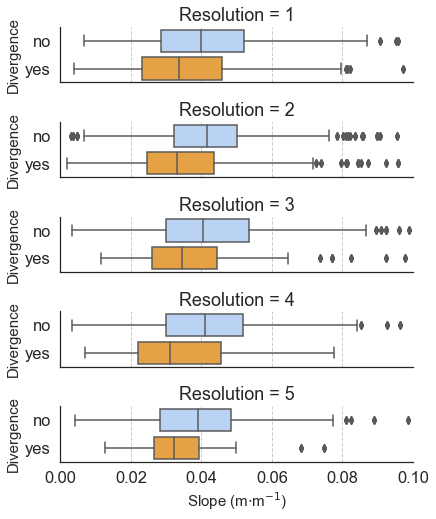

In [307]:
data = gully_head_dataframe
colours = {0:'xkcd:powder blue', 1:'xkcd:mango'}
g = sns.catplot(x="SA", y="DC", row="Resolution",
                kind="box", orient="h", height=1.5, aspect=4,
                data=data, palette = colours)
g.set(xlim=(0, 0.1))
plt.xlabel('Slope (m$\cdot$m$^{-1}$)', fontsize=15)
for ax in g.axes.flat:
    ax.set_ylabel('Divergence', fontsize=15)
    ax.set(yticklabels=['no', 'yes'])

In [311]:
all_data_1m_dataframe

,D4,D8,Dinf,M4,M8,node_id,DC,Slope,SA,Resolution
6369407,0.7936,0.4192,0.432222,0.584626,0.481259,6369407,0,0.043334,0.044079,1
8000074,0.5183,0.9929,1.024181,0.900704,0.962416,8000074,1,0.043282,0.040577,1
8402506,0.5654,0.5344,0.504951,0.546750,0.482315,8402506,0,0.048987,0.056838,1
9130277,0.8072,0.7289,0.728331,0.757537,0.464273,9130277,0,0.049699,0.022517,1
9183765,0.4843,0.8293,0.723900,0.759752,0.470430,9183765,0,0.048443,0.040390,1
...,...,...,...,...,...,...,...,...,...,...
62794131,0.0023,22.0751,22.088686,10.974792,15.353873,62794131,0,0.029851,0.022314,1
64129981,0.1730,0.0239,0.186611,0.294549,0.289628,64129981,1,0.026624,0.012048,1
65836953,2.1117,1.8009,1.801514,1.964746,1.910864,65836953,1,0.042981,0.032858,1
66631077,1.4384,1.5663,1.529028,1.505315,1.519280,66631077,1,0.047670,0.033483,1


In [633]:
conv_area = all_data_5m_dataframe.loc[all_data_5m_dataframe['DC'] == 0]['D4'].to_numpy()
div_area = all_data_5m_dataframe.loc[all_data_5m_dataframe['DC'] == 1]['D4'].to_numpy()
mean_conv_a = np.round(np.mean(conv_area),5)
mean_div_a = np.round(np.mean(div_area),5)

standard_deviation_convergent = np.std(np.array(conv_area))
standard_deviation_divergent = np.std(np.array(div_area))

In [634]:
print('Mean div: ', np.round(mean_div_a, 2), 'stdev: ', np.round(standard_deviation_divergent, 2))
print('Mean conv: ', np.round(mean_conv_a, 2), 'stdev: ', np.round(standard_deviation_convergent, 2))

Mean div:  3.44 stdev:  10.51
Mean conv:  1.86 stdev:  4.74


In [635]:
stat, p = mannwhitneyu(conv_area, div_area)

In [636]:
if p < 0.0005:
    p = '(***)'
elif p < 0.005:
    p = '(**)'
elif p < 0.05:
    p = '(*)'
else:
    p= '(ns)'

p

'(ns)'

In [473]:
# generate non-normal data (exponential) 
original_data = conv_slope
  
# transform training data & save lambda value 
fitted_data, fitted_lambda = stats.boxcox(v) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(original_data, hist = True, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", color ="green", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = True, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="green", ax = ax[1]) 
  
# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
  
print(f"Lambda value used for Transformation: {fitted_lambda}") 

NameError: name 'conv_slope' is not defined

In [364]:
from scipy.stats import normaltest

In [427]:
from scipy.stats import mannwhitneyu

In [424]:
stat, p = normaltest(md)

In [434]:
stat, p = mannwhitneyu(conv_area, div_area)

In [435]:
p

2.184049614799961e-08

Lambda value used for Transformation: -0.47148259571228596


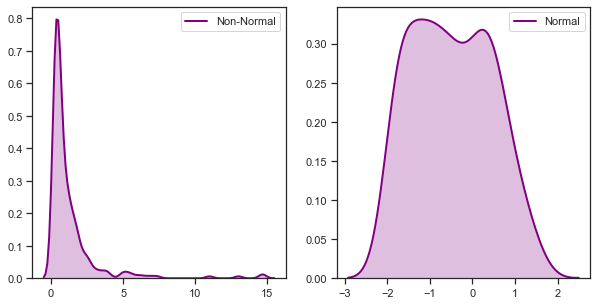

In [353]:
# generate non-normal data (exponential) 
original_data = div_area
  
# transform training data & save lambda value 
fitted_data, fitted_lambda = stats.boxcox(original_data) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(original_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", color ="purple", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="purple", ax = ax[1]) 
  
# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
  
print(f"Lambda value used for Transformation: {fitted_lambda}") 

In [354]:
stats.shapiro(fitted_data)

(0.9603593945503235, 1.5058583358040778e-06)

In [ ]:
degrees_of_freedom = np.min([len(conv_area), len(div_area)]) - 1

In [ ]:
test_of_significance_b = t.sf(t_value_b, degrees_of_freedom) * 2
test_of_significance_k = t.sf(t_value_k, degrees_of_freedom) * 2
print('Significant difference b: ', test_of_significance_b)
print('Significant difference k: ', test_of_significance_k)

In [339]:
from statsmodels.graphics.gofplots import qqplot

### $H_0$: $\mu_{conv}$  = $\mu_{div}$

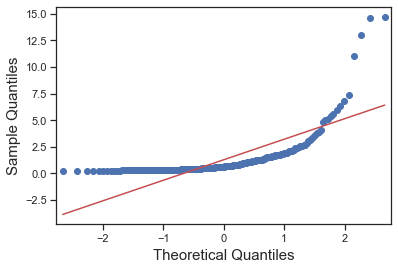

In [432]:
qqplot(div_area, line='s')
plt.show()

In [ ]:
catchment_areas_1m_divergent = gully_head_dataframe.loc[(gully_head_dataframe['DC'] == 1) & (gully_head_dataframe['Resolution'] == 1)]


In [ ]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [ ]:
np_array_to_Geotiff('grid_nodes_5m.tif', input_geotiff, grid_nodes_float, grid_nodes_float.dtype)